<a href="https://colab.research.google.com/github/Octave-Horlin/NLP/blob/main/LabTransformersTextClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Transformer Models for Text Classification

This notebook provides a hands-on guide to using Hugging Face transformer models for text classification tasks.

We'll build an emotion classification system using DistilBERT that can identify emotions from Twitter messages. We'll explore two main approaches: **feature extraction** (using transformer embeddings with a simple classifier) and **fine-tuning** (training the entire model end-to-end).


## A First Look at Hugging Face Datasets

We will use Datasets to download the data from the Hugging Face Hub. We can use the `list_datasets()` function to see what datasets are available on the Hub:


In [ ]:
from huggingface_hub import list_datasets
all_datasets = list(list_datasets())
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")


There are 579081 datasets currently available on the Hub
The first 10 are: [DatasetInfo(id='Anthropic/AnthropicInterviewer', author='Anthropic', sha='78962e1a1c817f90b7121982ea0dda56892f4424', created_at=datetime.datetime(2025, 12, 3, 6, 49, 55, tzinfo=datetime.timezone.utc), last_modified=datetime.datetime(2025, 12, 4, 16, 52, 17, tzinfo=datetime.timezone.utc), private=False, gated=False, disabled=False, downloads=2740, downloads_all_time=None, likes=109, paperswithcode_id=None, tags=['language:en', 'license:mit', 'size_categories:1K<n<10K', 'format:csv', 'modality:text', 'library:datasets', 'library:pandas', 'library:mlcroissant', 'library:polars', 'region:us'], trending_score=109, card_data=None, siblings=None, xet_enabled=None), DatasetInfo(id='nvidia/ToolScale', author='nvidia', sha='eb8c6aee519687b6a37c804855adab5525846d8a', created_at=datetime.datetime(2025, 11, 25, 23, 23, 21, tzinfo=datetime.timezone.utc), last_modified=datetime.datetime(2025, 11, 27, 4, 2, 56, tzinfo=datetime

We see that each dataset is given a name, so let's load the `emotion` dataset with the `load_dataset()` function:


In [ ]:
from datasets import load_dataset
emotions = load_dataset("emotion")


If we look inside our `emotions` object:


In [ ]:
emotions


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

we see it is similar to a Python dictionary, with each key corresponding to a different split. And we can use the usual dictionary syntax to access an individual split:


In [ ]:
train_ds = emotions["train"]
train_ds


Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

which returns an instance of the `Dataset` class. The `Dataset` object is one of the core data structures in `Datasets`, and we can think of it as behaving like an ordinary Python array or list. For example, we can query its length:


In [ ]:
len(train_ds)


16000

or access a single example by its index:


In [ ]:
train_ds[0]


{'text': 'i didnt feel humiliated', 'label': 0}

Here we see that a single row is represented as a dictionary, where the keys correspond to the column names:


In [ ]:
train_ds.column_names


['text', 'label']

The values in the dataset are a tweet and an emotion. `Datasets` is based on `Apache Arrow`, which provides a columnar memory format that is much more memory efficient than native Python. We can inspect the data types of our columns via the `features` attribute:


In [ ]:
print(train_ds.features)


{'text': Value('string'), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}


In this case, the data type of the `text` column is `string`, while the `label` column is a special `ClassLabel` object that contains information about the class names and their mapping to integers. We can also access several rows with a slice:


In [ ]:
print(train_ds[:5])


{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


Note that in this case, the dictionary values are now lists instead of individual elements. We can also get the full column by name:


In [ ]:
print(train_ds["text"][:5])


['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


## Exercise 1: Dataset Exploration

Now that you've seen how to load and explore the `emotion` dataset, try the following:

**Question 1:** Browse the Hugging Face Datasets Hub and find another text classification dataset (e.g., `imdb`, `ag_news`, or `yelp_review_full`). Load this dataset and explore its structure. How many classes does it have? How is it different from the `emotion` dataset?

**Question 2:** The current dataset is imbalanced. Using the Pandas documentation, research and implement at least one strategy to handle class imbalance (e.g., using `resample()` or `sample()` with weights). What effect do you expect this to have on model performance?

💡 **Hint:** Check the Hugging Face Datasets documentation for loading different datasets and the `imbalanced-learn` documentation for sampling strategies.


### Question 1: Exploring Another Text Classification Dataset

Let's load and explore the IMDB dataset for comparison:


In [ ]:
# Load the IMDB dataset
imdb = load_dataset("imdb")
imdb


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
# Explore the structure
imdb_train = imdb["train"]
print(f"Number of training examples: {len(imdb_train)}")
print(f"Columns: {imdb_train.column_names}")
print(f"\nFeatures: {imdb_train.features}")
print(f"\nFirst example: {imdb_train[0]}")
print(f"\nFirst 3 examples:\n{imdb_train[:3]}")


Number of training examples: 25000
Columns: ['text', 'label']

Features: {'text': Value('string'), 'label': ClassLabel(names=['neg', 'pos'])}

First example: {'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<b

In [ ]:
# Count the number of classes
import pandas as pd

# Convert to DataFrame for easier analysis
imdb_df = pd.DataFrame(imdb_train)
print(f"Number of classes in IMDB: {imdb_df['label'].nunique()}")
print(f"Class distribution:\n{imdb_df['label'].value_counts().sort_index()}")
print(f"\nClass names: {imdb_train.features['label'].names if hasattr(imdb_train.features['label'], 'names') else 'Binary (0=neg, 1=pos)'}")


Number of classes in IMDB: 2
Class distribution:
label
0    12500
1    12500
Name: count, dtype: int64

Class names: ['neg', 'pos']


**Comparison with emotion dataset:**


In [ ]:
# Compare emotion and IMDB datasets
emotion_train = emotions["train"]
emotion_df = pd.DataFrame(emotion_train)

print("=== EMOTION DATASET ===")
print(f"Number of classes: {emotion_df['label'].nunique()}")
print(f"Class names: {emotion_train.features['label'].names}")
print(f"Training examples: {len(emotion_train)}")
print(f"Class distribution:\n{emotion_df['label'].value_counts().sort_index()}")

print("\n=== IMDB DATASET ===")
print(f"Number of classes: {imdb_df['label'].nunique()}")
print(f"Training examples: {len(imdb_train)}")
print(f"Class distribution:\n{imdb_df['label'].value_counts().sort_index()}")

print("\n=== KEY DIFFERENCES ===")
print(f"1. Number of classes: emotion has {emotion_df['label'].nunique()} classes, IMDB has {imdb_df['label'].nunique()} classes")
print(f"2. Task type: emotion is multi-class ({emotion_df['label'].nunique()} emotions), IMDB is binary (sentiment: positive/negative)")
print(f"3. Text length: emotion contains short tweets, IMDB contains full movie reviews")
print(f"4. Domain: emotion is from Twitter, IMDB is from movie reviews")


=== EMOTION DATASET ===
Number of classes: 6
Class names: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
Training examples: 16000
Class distribution:
label
0    4666
1    5362
2    1304
3    2159
4    1937
5     572
Name: count, dtype: int64

=== IMDB DATASET ===
Number of classes: 2
Training examples: 25000
Class distribution:
label
0    12500
1    12500
Name: count, dtype: int64

=== KEY DIFFERENCES ===
1. Number of classes: emotion has 6 classes, IMDB has 2 classes
2. Task type: emotion is multi-class (6 emotions), IMDB is binary (sentiment: positive/negative)
3. Text length: emotion contains short tweets, IMDB contains full movie reviews
4. Domain: emotion is from Twitter, IMDB is from movie reviews


### Question 2: Handling Class Imbalance

First, let's analyze the class distribution in the emotion dataset:


In [ ]:
# Analyze class imbalance in emotion dataset
emotion_train_df = pd.DataFrame(emotion_train)
class_counts = emotion_train_df['label'].value_counts().sort_index()
class_names = emotion_train.features['label'].names

print("Class distribution in emotion dataset:")
for idx, count in class_counts.items():
    class_name = class_names[idx]
    percentage = (count / len(emotion_train_df)) * 100
    print(f"{class_name} (label {idx}): {count} examples ({percentage:.2f}%)")

print(f"\nTotal examples: {len(emotion_train_df)}")
print(f"\nImbalance ratio (max/min): {class_counts.max() / class_counts.min():.2f}x")


Class distribution in emotion dataset:
sadness (label 0): 4666 examples (29.16%)
joy (label 1): 5362 examples (33.51%)
love (label 2): 1304 examples (8.15%)
anger (label 3): 2159 examples (13.49%)
fear (label 4): 1937 examples (12.11%)
surprise (label 5): 572 examples (3.57%)

Total examples: 16000

Imbalance ratio (max/min): 9.37x


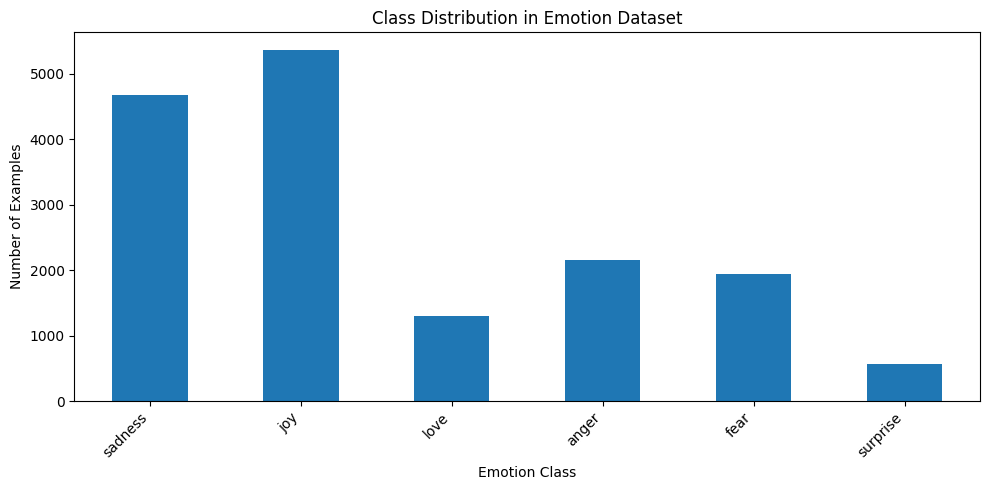

In [ ]:
# Visualize class distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
class_counts.plot(kind='bar')
plt.title('Class Distribution in Emotion Dataset')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Examples')
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.tight_layout()
plt.show()


Now let's implement a resampling strategy using `resample()` from pandas:


In [ ]:
# Strategy 1: Oversample minority classes using resample()
from sklearn.utils import resample

# Separate majority and minority classes
majority_class = class_counts.idxmax()
majority_count = class_counts.max()

# Create balanced dataset by oversampling minority classes
balanced_dfs = []

for label_idx in range(len(class_names)):
    class_data = emotion_train_df[emotion_train_df['label'] == label_idx]

    if len(class_data) < majority_count:
        # Oversample minority class
        resampled = resample(class_data,
                           replace=True,  # Sample with replacement
                           n_samples=majority_count,  # Match majority class size
                           random_state=42)
        balanced_dfs.append(resampled)
    else:
        # Keep majority class as is
        balanced_dfs.append(class_data)

# Combine all classes
emotion_balanced_df = pd.concat(balanced_dfs, ignore_index=True)

# Shuffle the dataset
emotion_balanced_df = emotion_balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("After oversampling:")
print(emotion_balanced_df['label'].value_counts().sort_index())
print(f"\nTotal examples after balancing: {len(emotion_balanced_df)}")
print(f"Original size: {len(emotion_train_df)}")
print(f"New size: {len(emotion_balanced_df)} (increase of {len(emotion_balanced_df) - len(emotion_train_df)} examples)")


After oversampling:
label
0    5362
1    5362
2    5362
3    5362
4    5362
5    5362
Name: count, dtype: int64

Total examples after balancing: 32172
Original size: 16000
New size: 32172 (increase of 16172 examples)


Alternative strategy: Using sample weights instead of resampling:


In [ ]:
# Strategy 2: Use sample weights (doesn't change dataset size, just weights during training)
# Calculate inverse class frequencies as weights
class_weights = {}
total_samples = len(emotion_train_df)

for label_idx in range(len(class_names)):
    class_count = class_counts[label_idx]
    # Weight inversely proportional to class frequency
    weight = total_samples / (len(class_names) * class_count)
    class_weights[label_idx] = weight

print("Sample weights for each class (inverse frequency weighting):")
for label_idx, weight in class_weights.items():
    class_name = class_names[label_idx]
    print(f"{class_name} (label {label_idx}): {weight:.4f}")

# Create a weight column for each sample
emotion_train_df['sample_weight'] = emotion_train_df['label'].map(class_weights)
print(f"\nSample weights assigned. Dataset size remains: {len(emotion_train_df)}")


Sample weights for each class (inverse frequency weighting):
sadness (label 0): 0.5715
joy (label 1): 0.4973
love (label 2): 2.0450
anger (label 3): 1.2351
fear (label 4): 1.3767
surprise (label 5): 4.6620

Sample weights assigned. Dataset size remains: 16000


**Expected effects on model performance:**

1. **Oversampling (resample()):**
   - **Pros:** Model sees more examples of minority classes, learns better patterns for underrepresented emotions
   - **Cons:** May lead to overfitting on minority classes, longer training time due to larger dataset
   - **Expected:** Better recall for minority classes (sadness, fear, surprise), more balanced confusion matrix

2. **Sample weights:**
   - **Pros:** No dataset size increase, model focuses more on minority classes during training
   - **Cons:** May be less effective than oversampling for very imbalanced datasets
   - **Expected:** Similar improvements to oversampling but with original dataset size

3. **Overall impact:**
   - Better performance on minority classes (reduced false negatives)
   - More balanced precision/recall across all classes
   - Potentially slightly lower overall accuracy but better F1-score (macro-averaged)
   - More robust model that doesn't just predict majority class


## From Text to Tokens - Summary

**Overview:** Transformer models don't accept raw text. We need to convert text into tokens (atomic units) and then into numerical vectors. This section explores three tokenization strategies:

1. **Character Tokenization**: Split text into individual characters. Rarely used because it ignores linguistic structure and requires models to learn words from characters, needing significant compute, memory, and data.

2. **Word Tokenization**: Split text into words using whitespace. Simple but creates large vocabularies (millions of words), leading to huge model parameters. Common words are kept, rare words are marked as `UNK` (unknown), causing information loss.

3. **Subword Tokenization** (used by DistilBERT): Best compromise - splits rare words into smaller units (subwords) while keeping frequent words intact. Uses WordPiece algorithm learned from pretraining corpus. Vocabulary size: 30,522 tokens. Max context length: 512 tokens.

**Key Concepts:**
- **Tokenization**: Breaking text into tokens
- **Numericalization**: Converting tokens to integers (`input_ids`)
- **Special tokens**: `[CLS]` (start), `[SEP]` (end), `[PAD]` (padding), `[UNK]` (unknown), `[MASK]` (masked)
- **Attention mask**: Binary array indicating which tokens are real (1) vs padding (0)
- **Padding**: Making all sequences the same length by adding zeros
- **Truncation**: Cutting sequences longer than max_length (512 for DistilBERT)

**Implementation:**
- Load tokenizer: `AutoTokenizer.from_pretrained("distilbert-base-uncased")`
- Tokenize function: `tokenizer(batch["text"], padding=True, truncation=True)`
- Apply to dataset: `emotions.map(tokenize, batched=True, batch_size=None)`
- Result: Adds `input_ids` and `attention_mask` columns to the dataset

**Important:** Always use the same tokenizer that the model was trained with. Switching tokenizers is like shuffling the vocabulary from the model's perspective.


## Training a Text Classifier - Summary

**Overview:** Pre-trained models like DistilBERT are initially trained to predict masked words. To adapt them for text classification, we need to modify the architecture by replacing the language modeling layer with a classification layer.

**Architecture Flow:**
1. Text → Tokenization → Token encodings (one-hot vectors, vocab size: 20k-200k)
2. Token encodings → Token embeddings (lower-dimensional vectors)
3. Token embeddings → Encoder layers → Hidden states (one per input token)
4. For classification: Hidden states → Classification layer (instead of language modeling layer)

**Two Approaches:**

1. **Feature Extraction:**
   - Freeze the pre-trained Transformer weights
   - Extract hidden states (embeddings) as features
   - Train a simple classifier (e.g., linear layer, random forest) on these features
   - **Advantages:** Fast, no GPU needed during classifier training, features precomputed once
   - **Use case:** Quick prototyping, limited compute resources

2. **Fine-tuning:**
   - Train the entire model end-to-end
   - Update all Transformer parameters
   - **Advantages:** Usually better performance, model adapts to task
   - **Use case:** When you have compute resources and want best performance

**Implementation:**
- Load model: `AutoModel.from_pretrained("distilbert-base-uncased")`
- Device selection: `torch.device("cuda" if torch.cuda.is_available() else "cpu")`
- Move model to device: `model.to(device)`

**Note:** PyTorch skips creating one-hot vectors directly - it uses `nn.Embedding` which efficiently selects columns from the embedding matrix using token IDs.


## Exercise 2: Tokenization Experiments

Now that you understand how tokenization works, let's experiment with different tokenizers and parameters:

**Question 1:** Load and compare different pre-trained model tokenizers (e.g., `bert-base-cased`, `roberta-base`, `albert-base-v2`) with the `DistilBERT` tokenizer. Use the Hugging Face Models Hub to find these models. How do their tokenizations differ? What is the difference between `cased` and `uncased` tokenizers?

**Question 2:** Experiment with the `padding` and `truncation` parameters of a tokenizer. What happens when you set `max_length=10` and `truncation=True`? Read the tokenizer documentation to understand different padding strategies (like `max_length`, `longest`, `do_not_pad`).

💡 **Hint:** Try tokenizing the same text with different tokenizers and compare the outputs. Also experiment with different padding and truncation settings to see how they affect the tokenized sequences.


### Question 1: Comparing Different Tokenizers

Let's load and compare different tokenizers with DistilBERT:


In [ ]:
from transformers import AutoTokenizer

# Test text
text = "Hello World! This is a test sentence with UPPERCASE and lowercase words."

# Load different tokenizers
tokenizers = {
    "DistilBERT (uncased)": AutoTokenizer.from_pretrained("distilbert-base-uncased"),
    "BERT (cased)": AutoTokenizer.from_pretrained("bert-base-cased"),
    "BERT (uncased)": AutoTokenizer.from_pretrained("bert-base-uncased"),
    "RoBERTa": AutoTokenizer.from_pretrained("roberta-base"),
    "ALBERT": AutoTokenizer.from_pretrained("albert-base-v2")
}

print("Tokenizing the same text with different tokenizers:\n")
print(f"Original text: {text}\n")
print("=" * 80)


Tokenizing the same text with different tokenizers:

Original text: Hello World! This is a test sentence with UPPERCASE and lowercase words.



In [ ]:
# Compare tokenizations
for name, tokenizer in tokenizers.items():
    encoded = tokenizer(text)
    tokens = tokenizer.convert_ids_to_tokens(encoded.input_ids)

    print(f"\n{name}:")
    print(f"  Vocabulary size: {tokenizer.vocab_size}")
    print(f"  Max length: {tokenizer.model_max_length}")
    print(f"  Number of tokens: {len(tokens)}")
    print(f"  Tokens: {tokens}")
    print(f"  Input IDs: {encoded.input_ids[:10]}...")  # Show first 10
    print("-" * 80)



DistilBERT (uncased):
  Vocabulary size: 30522
  Max length: 512
  Number of tokens: 18
  Tokens: ['[CLS]', 'hello', 'world', '!', 'this', 'is', 'a', 'test', 'sentence', 'with', 'upper', '##case', 'and', 'lower', '##case', 'words', '.', '[SEP]']
  Input IDs: [101, 7592, 2088, 999, 2023, 2003, 1037, 3231, 6251, 2007]...
--------------------------------------------------------------------------------

BERT (cased):
  Vocabulary size: 28996
  Max length: 512
  Number of tokens: 21
  Tokens: ['[CLS]', 'Hello', 'World', '!', 'This', 'is', 'a', 'test', 'sentence', 'with', 'UP', '##P', '##ER', '##CA', '##SE', 'and', 'lower', '##case', 'words', '.', '[SEP]']
  Input IDs: [101, 8667, 1291, 106, 1188, 1110, 170, 2774, 5650, 1114]...
--------------------------------------------------------------------------------

BERT (uncased):
  Vocabulary size: 30522
  Max length: 512
  Number of tokens: 18
  Tokens: ['[CLS]', 'hello', 'world', '!', 'this', 'is', 'a', 'test', 'sentence', 'with', 'upper', '##

**Key Observations:**


In [ ]:
# Compare cased vs uncased specifically
print("=== CASED vs UNCASED Comparison ===\n")

cased_text = "Hello World! UPPERCASE lowercase"
bert_cased = AutoTokenizer.from_pretrained("bert-base-cased")
bert_uncased = AutoTokenizer.from_pretrained("bert-base-uncased")

print(f"Original text: {cased_text}\n")

cased_tokens = bert_cased.convert_ids_to_tokens(bert_cased(cased_text).input_ids)
uncased_tokens = bert_uncased.convert_ids_to_tokens(bert_uncased(cased_text).input_ids)

print("BERT Cased tokens:")
print(f"  {cased_tokens}")
print("\nBERT Uncased tokens:")
print(f"  {uncased_tokens}")

print("\n" + "=" * 80)
print("\n**Difference between cased and uncased:**")
print("- **Cased tokenizers**: Preserve the original capitalization of words")
print("  - 'Hello' and 'hello' are treated as different tokens")
print("  - Useful for tasks where capitalization matters (e.g., named entity recognition)")
print("- **Uncased tokenizers**: Convert all text to lowercase before tokenization")
print("  - 'Hello' and 'hello' become the same token")
print("  - Reduces vocabulary size, useful for general text classification")


=== CASED vs UNCASED Comparison ===

Original text: Hello World! UPPERCASE lowercase

BERT Cased tokens:
  ['[CLS]', 'Hello', 'World', '!', 'UP', '##P', '##ER', '##CA', '##SE', 'lower', '##case', '[SEP]']

BERT Uncased tokens:
  ['[CLS]', 'hello', 'world', '!', 'upper', '##case', 'lower', '##case', '[SEP]']


**Difference between cased and uncased:**
- **Cased tokenizers**: Preserve the original capitalization of words
  - 'Hello' and 'hello' are treated as different tokens
  - Useful for tasks where capitalization matters (e.g., named entity recognition)
- **Uncased tokenizers**: Convert all text to lowercase before tokenization
  - 'Hello' and 'hello' become the same token
  - Reduces vocabulary size, useful for general text classification


### Question 2: Experimenting with Padding and Truncation

Let's experiment with different padding and truncation strategies:


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Test with a longer text
long_text = "This is a very long sentence that will definitely exceed the maximum length we set. " * 3
print(f"Original text length: {len(long_text)} characters\n")
print(f"Text: {long_text[:100]}...\n")
print("=" * 80)


Original text length: 252 characters

Text: This is a very long sentence that will definitely exceed the maximum length we set. This is a very l...



In [ ]:
# Test 1: max_length=10 with truncation=True
print("=== Test 1: max_length=10, truncation=True ===\n")
encoded1 = tokenizer(long_text, max_length=10, truncation=True, padding=False)
tokens1 = tokenizer.convert_ids_to_tokens(encoded1.input_ids)
print(f"Number of tokens: {len(tokens1)}")
print(f"Tokens: {tokens1}")
print(f"Input IDs: {encoded1.input_ids}")
print(f"Attention mask: {encoded1.attention_mask}")
print(f"\nDecoded back: {tokenizer.decode(encoded1.input_ids)}")
print("\n" + "-" * 80)


=== Test 1: max_length=10, truncation=True ===

Number of tokens: 10
Tokens: ['[CLS]', 'this', 'is', 'a', 'very', 'long', 'sentence', 'that', 'will', '[SEP]']
Input IDs: [101, 2023, 2003, 1037, 2200, 2146, 6251, 2008, 2097, 102]
Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Decoded back: [CLS] this is a very long sentence that will [SEP]

--------------------------------------------------------------------------------


In [ ]:
# Test 2: Different padding strategies
print("=== Test 2: Different Padding Strategies ===\n")

texts = [
    "Short text.",
    "This is a medium length sentence with several words.",
    "This is a very long sentence that contains many words and will be used to test padding behavior."
]

print("Original texts:")
for i, txt in enumerate(texts):
    print(f"  {i+1}. {txt}")

print("\n" + "-" * 80)


=== Test 2: Different Padding Strategies ===

Original texts:
  1. Short text.
  2. This is a medium length sentence with several words.
  3. This is a very long sentence that contains many words and will be used to test padding behavior.

--------------------------------------------------------------------------------


In [ ]:
# Padding strategy: max_length
print("\n1. Padding with max_length=50:")
encoded_max = tokenizer(texts, padding="max_length", max_length=50, truncation=True)
print(f"   All sequences padded/truncated to length: {len(encoded_max['input_ids'][0])}")
for i, ids in enumerate(encoded_max['input_ids']):
    print(f"   Text {i+1}: {len([x for x in ids if x != 0])} real tokens, {len(ids)} total (with padding)")
print(f"   Attention masks: {encoded_max['attention_mask']}")

# Padding strategy: longest
print("\n2. Padding with longest (pads to longest sequence in batch):")
encoded_longest = tokenizer(texts, padding="longest", truncation=True)
print(f"   Longest sequence length: {max(len(ids) for ids in encoded_longest['input_ids'])}")
for i, ids in enumerate(encoded_longest['input_ids']):
    print(f"   Text {i+1}: {len(ids)} tokens")
print(f"   Attention masks: {encoded_longest['attention_mask']}")

# No padding
print("\n3. No padding (do_not_pad):")
encoded_no_pad = tokenizer(texts, padding=False, truncation=True)
for i, ids in enumerate(encoded_no_pad['input_ids']):
    print(f"   Text {i+1}: {len(ids)} tokens (no padding)")



1. Padding with max_length=50:
   All sequences padded/truncated to length: 50
   Text 1: 5 real tokens, 50 total (with padding)
   Text 2: 12 real tokens, 50 total (with padding)
   Text 3: 22 real tokens, 50 total (with padding)
   Attention masks: [[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

2. Padding with longest (pads to longest sequence in batch):
   Longest sequence length: 22
   Text 1: 22 tokens
   Text 2: 22 tokens
   Text 3: 22 tokens
   Attention masks: [[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 

**Summary of Padding and Truncation:**

1. **`truncation=True`**: Cuts off sequences longer than `max_length` (or model's default max length)
   - When `max_length=10`: Only first 10 tokens are kept, rest is discarded
   - Important: Information loss occurs for truncated sequences

2. **Padding Strategies:**
   - **`max_length`**: Pads/truncates all sequences to a fixed length (specified by `max_length`)
   - **`longest`**: Pads all sequences to match the longest sequence in the batch (no truncation unless `truncation=True`)
   - **`do_not_pad`** or `False`: No padding applied, sequences keep their original lengths

3. **Attention Mask**: Always created when padding is used, tells the model which tokens are real (1) vs padding (0)

**When to use each:**
- `max_length`: When you need fixed-size batches for efficient GPU processing
- `longest`: When you want to preserve all information but need batches of same length
- `do_not_pad`: When processing sequences individually or when using dynamic padding with data collators


## Transformers as Feature Extractors - Summary

**Overview:** This section demonstrates the **feature extraction approach** - using a pre-trained Transformer (DistilBERT) to extract embeddings, then training a simple classifier on these features.

**Process Flow:**

1. **Load Pre-trained Model:**
   - `AutoModel.from_pretrained("distilbert-base-uncased")` - Loads DistilBERT
   - Move to device (GPU if available, else CPU)

2. **Extract Hidden States:**
   - Tokenize text → `input_ids`, `attention_mask`
   - Pass to model → Get `last_hidden_state` (shape: `[batch_size, n_tokens, 768]`)
   - Extract `[CLS]` token hidden state (index 0) → 768-dimensional vector per tweet
   - Function: `extract_hidden_states()` processes batches efficiently

3. **Create Feature Matrix:**
   - Convert hidden states to NumPy arrays: `X_train`, `X_valid` (shape: `[n_samples, 768]`)
   - Extract labels: `y_train`, `y_valid`

4. **Visualize Embeddings (UMAP):**
   - Reduce dimensions: 768D → 2D using UMAP
   - Scale features with `MinMaxScaler` first
   - Plot density maps for each emotion
   - **Observation:** Positive emotions (joy, love) separated from negative ones (sadness, anger, fear)

5. **Train Simple Classifier:**
   - Logistic Regression from Scikit-Learn
   - Fast training, no GPU needed
   - **Results:** 60.85% accuracy (vs 35.2% baseline)

6. **Evaluate with Confusion Matrix:**
   - **Key confusions:**
     - Anger/Fear → often predicted as Sadness
     - Love/Surprise → often predicted as Joy
   - Shows model struggles with similar emotions

**Key Concepts:**
- **Hidden states**: Rich numerical representations (embeddings) from Transformer layers
- **`[CLS]` token**: Special token whose hidden state represents the entire sequence
- **Feature extraction**: Freeze Transformer weights, only train classifier
- **UMAP**: Dimensionality reduction technique for visualization

**Advantages of Feature Extraction:**
- Fast training (no GPU needed for classifier)
- Features precomputed once
- Good baseline performance
- Useful when compute resources are limited


## Fine-Tuning Transformers - Summary

**Overview:** Fine-tuning trains the entire Transformer model end-to-end, including both the pre-trained Transformer weights and a new classification head. This adapts the model's internal representations specifically for your task, leading to better performance than feature extraction.

**Key Difference from Feature Extraction:**
- **Feature Extraction**: Freeze Transformer, only train classifier on fixed embeddings
- **Fine-Tuning**: Train entire model (Transformer + classification head), adapts hidden states to task

**Process:**

1. **Load Pre-trained Model for Classification:**
   - Use `AutoModelForSequenceClassification` (not `AutoModel`)
   - Automatically adds a classification head on top of the Transformer
   - Specify `num_labels=6` (number of emotion classes)
   - Classification head is randomly initialized (will be trained)

2. **Define Performance Metrics:**
   - Create `compute_metrics()` function for the Trainer
   - Receives `EvalPrediction` object (predictions, label_ids)
   - Returns dictionary with metrics: F1-score (weighted) and accuracy
   - Uses `argmax(-1)` to convert logits to predicted labels

3. **Prepare for Training:**
   - Login to Hugging Face Hub: `notebook_login()` (to push/share model later)
   - Define hyperparameters (learning rate, batch size, epochs, etc.)
   - Use `Trainer` API to simplify training process

**Key Concepts:**
- **Fine-tuning**: Training entire model end-to-end, adapting pre-trained weights
- **Classification head**: Neural network layer added on top of Transformer for classification
- **Trainer API**: Hugging Face utility that handles training loop, evaluation, logging
- **Logits**: Raw model outputs before softmax (need `argmax` to get predictions)

**Advantages of Fine-Tuning:**
- Better performance (model adapts to task)
- Learns task-specific representations
- Can achieve state-of-the-art results

**Disadvantages:**
- Requires more compute (GPU recommended)
- Longer training time
- More hyperparameters to tune


### Feature Extraction: Creating X_train, y_train, X_valid, y_valid

Before running Exercise 3, we need to extract the hidden states from DistilBERT to create our feature matrices:


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
import numpy as np

# Load tokenizer and model
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Load and tokenize dataset
emotions = load_dataset("emotion")

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

# Function to extract hidden states
def extract_hidden_states(batch):
    # Convert lists to tensors properly for batched processing
    inputs = {}
    for k, v in batch.items():
        if k in tokenizer.model_input_names:
            # v is a list of lists when batched=True, convert to tensor
            inputs[k] = torch.tensor(v, device=device)
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Extract [CLS] token (first token) for each sequence
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

# Extract hidden states (process in smaller batches to avoid memory issues)
emotions_hidden = emotions_encoded.map(
    extract_hidden_states,
    batched=True,
    batch_size=16  # Process 16 examples at a time
)

# Create feature matrices
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

print(f"X_train shape: {X_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_valid shape: {y_valid.shape}")

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

X_train shape: (16000, 768)
X_valid shape: (2000, 768)
y_train shape: (16000,)
y_valid shape: (2000,)


## Exercise 3: Feature Extraction and Model Selection

Now that you've seen how feature extraction works with logistic regression, let's experiment with different classifiers and visualization parameters:

**Question 1:** Try different classifiers from the `scikit-learn` library as alternatives to logistic regression. Test at least two of the following: `RandomForestClassifier`, `SVC` (Support Vector Classifier), or `MLPClassifier` (Neural Network). Compare their performance with logistic regression. Which one works best and why?

**Question 2:** The default UMAP visualization uses `n_components=2` and `metric="cosine"`. Read the UMAP documentation and experiment with different values for `n_components` (try 3), `metric` (try "euclidean"), and `n_neighbors` parameters. How do these parameter changes affect the visualization? What insights can you gain from the different visualizations?

💡 **Hint:** For Question 1, make sure to use the same feature matrix (hidden states) extracted from DistilBERT. For Question 2, remember to scale the features before applying UMAP.


### Question 1: Comparing Different Classifiers

Let's test different classifiers on the same DistilBERT embeddings:


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
import time

# Assuming we have X_train, X_valid, y_train, y_valid from previous feature extraction
# If not, we need to extract hidden states first
# For this exercise, we'll assume they exist or extract them

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=3000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVC": SVC(kernel='rbf', random_state=42),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

results = {}

print("Training and evaluating different classifiers:\n")
print("=" * 80)


Training and evaluating different classifiers:



In [ ]:
# Train and evaluate each classifier
for name, clf in classifiers.items():
    print(f"\n{name}:")
    print("-" * 80)

    # Train
    start_time = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Predict
    start_time = time.time()
    y_pred = clf.predict(X_valid)
    predict_time = time.time() - start_time

    # Evaluate
    accuracy = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average='weighted')

    results[name] = {
        'accuracy': accuracy,
        'f1': f1,
        'train_time': train_time,
        'predict_time': predict_time
    }

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-score (weighted): {f1:.4f}")
    print(f"  Training time: {train_time:.2f}s")
    print(f"  Prediction time: {predict_time:.4f}s")



Logistic Regression:
--------------------------------------------------------------------------------
  Accuracy: 0.6340
  F1-score (weighted): 0.6218
  Training time: 126.88s
  Prediction time: 0.0087s

Random Forest:
--------------------------------------------------------------------------------
  Accuracy: 0.5165
  F1-score (weighted): 0.4291
  Training time: 11.17s
  Prediction time: 0.1396s

SVC:
--------------------------------------------------------------------------------
  Accuracy: 0.5830
  F1-score (weighted): 0.5181
  Training time: 187.71s
  Prediction time: 24.8274s

MLP Classifier:
--------------------------------------------------------------------------------
  Accuracy: 0.5950
  F1-score (weighted): 0.5918
  Training time: 177.16s
  Prediction time: 0.0194s


In [ ]:
# Compare results
print("\n" + "=" * 80)
print("COMPARISON SUMMARY")
print("=" * 80)

comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.sort_values('f1', ascending=False)
print(comparison_df)

print("\n" + "=" * 80)
print("Best classifier:", comparison_df.index[0])
print(f"  Accuracy: {comparison_df.iloc[0]['accuracy']:.4f}")
print(f"  F1-score: {comparison_df.iloc[0]['f1']:.4f}")



COMPARISON SUMMARY
                     accuracy        f1  train_time  predict_time
Logistic Regression    0.6340  0.621821  126.884960      0.008700
MLP Classifier         0.5950  0.591796  177.160262      0.019434
SVC                    0.5830  0.518067  187.708874     24.827423
Random Forest          0.5165  0.429057   11.169994      0.139610

Best classifier: Logistic Regression
  Accuracy: 0.6340
  F1-score: 0.6218


**Analysis and Discussion:**

Each classifier has different characteristics:
- **Logistic Regression**: Fast, interpretable, good baseline
- **Random Forest**: Can capture non-linear relationships, robust to overfitting
- **SVC**: Good for high-dimensional data, can handle non-linear boundaries with RBF kernel
- **MLP Classifier**: Neural network, can learn complex patterns but may overfit

The best classifier depends on the trade-off between accuracy, training time, and interpretability.


### Question 2: Experimenting with UMAP Parameters

Let's explore how different UMAP parameters affect the visualization:


In [ ]:
import os
os.environ["UMAP_DISABLE_PARAMETRIC"] = "1"  # évite parametric_umap/TensorFlow

import umap.umap_ as umap
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Scale features
X_scaled = MinMaxScaler().fit_transform(X_train)

print("=== Default UMAP (n_components=2, metric='cosine') ===")
mapper_default = umap.UMAP(n_components=2, metric='cosine', random_state=42)
embedding_default = mapper_default.fit_transform(X_scaled)
print(f"Shape: {embedding_default.shape}")
print(f"First 5 points:\n{embedding_default[:5]}\n")

=== Default UMAP (n_components=2, metric='cosine') ===


c:\Users\octav\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shape: (16000, 2)
First 5 points:
[[ 4.1199775  3.1674318]
 [-3.1141672  3.9238024]
 [ 5.3228817  6.684471 ]
 [-2.5705311  5.895269 ]
 [-3.6665015  5.7766986]]



In [ ]:
print("=== Experiment 1: n_components=3 (3D) ===")
mapper_3d = umap.UMAP(n_components=3, metric='cosine', random_state=42)
embedding_3d = mapper_3d.fit_transform(X_scaled)
print(f"Shape: {embedding_3d.shape}")
print(f"First 5 points:\n{embedding_3d[:5]}\n")

=== Experiment 1: n_components=3 (3D) ===


c:\Users\octav\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shape: (16000, 3)
First 5 points:
[[ 2.6594124   5.0488667   4.5167623 ]
 [-3.0978093   5.26328    -0.47414103]
 [ 4.8053465   6.55282     3.876821  ]
 [-2.5218742   6.8388224   0.26367816]
 [-2.8932323   6.953349   -0.47588053]]



In [ ]:
# Experiment 2: metric='euclidean'
print("=== Experiment 2: metric='euclidean' ===\n")
mapper_euclidean = umap.UMAP(n_components=2, metric='euclidean', random_state=42)
embedding_euclidean = mapper_euclidean.fit_transform(X_scaled)
print(f"Shape: {embedding_euclidean.shape}")
print(f"First 5 points:\n{embedding_euclidean[:5]}\n")


=== Experiment 2: metric='euclidean' ===



c:\Users\octav\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shape: (16000, 2)
First 5 points:
[[ 4.2398486  4.305761 ]
 [-2.9703941  5.4369626]
 [ 5.3673787  7.7037477]
 [-2.2129219  7.491265 ]
 [-3.2044888  7.3298945]]



In [ ]:
# Experiment 3: Different n_neighbors values
print("=== Experiment 3: Different n_neighbors ===\n")

n_neighbors_values = [5, 15, 50, 100]
embeddings_neighbors = {}

for n_neigh in n_neighbors_values:
    mapper = umap.UMAP(n_components=2, metric='cosine', n_neighbors=n_neigh, random_state=42)
    embedding = mapper.fit_transform(X_scaled)
    embeddings_neighbors[n_neigh] = embedding
    print(f"n_neighbors={n_neigh}: Shape {embedding.shape}, Range X: [{embedding[:, 0].min():.2f}, {embedding[:, 0].max():.2f}], Range Y: [{embedding[:, 1].min():.2f}, {embedding[:, 1].max():.2f}]")


=== Experiment 3: Different n_neighbors ===



c:\Users\octav\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=5: Shape (16000, 2), Range X: [-4.40, 9.96], Range Y: [-1.56, 9.26]


c:\Users\octav\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15: Shape (16000, 2), Range X: [-5.04, 6.88], Range Y: [0.77, 9.01]


c:\Users\octav\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=50: Shape (16000, 2), Range X: [-7.69, 3.13], Range Y: [1.59, 8.93]


c:\Users\octav\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=100: Shape (16000, 2), Range X: [-9.03, 1.63], Range Y: [3.77, 10.23]


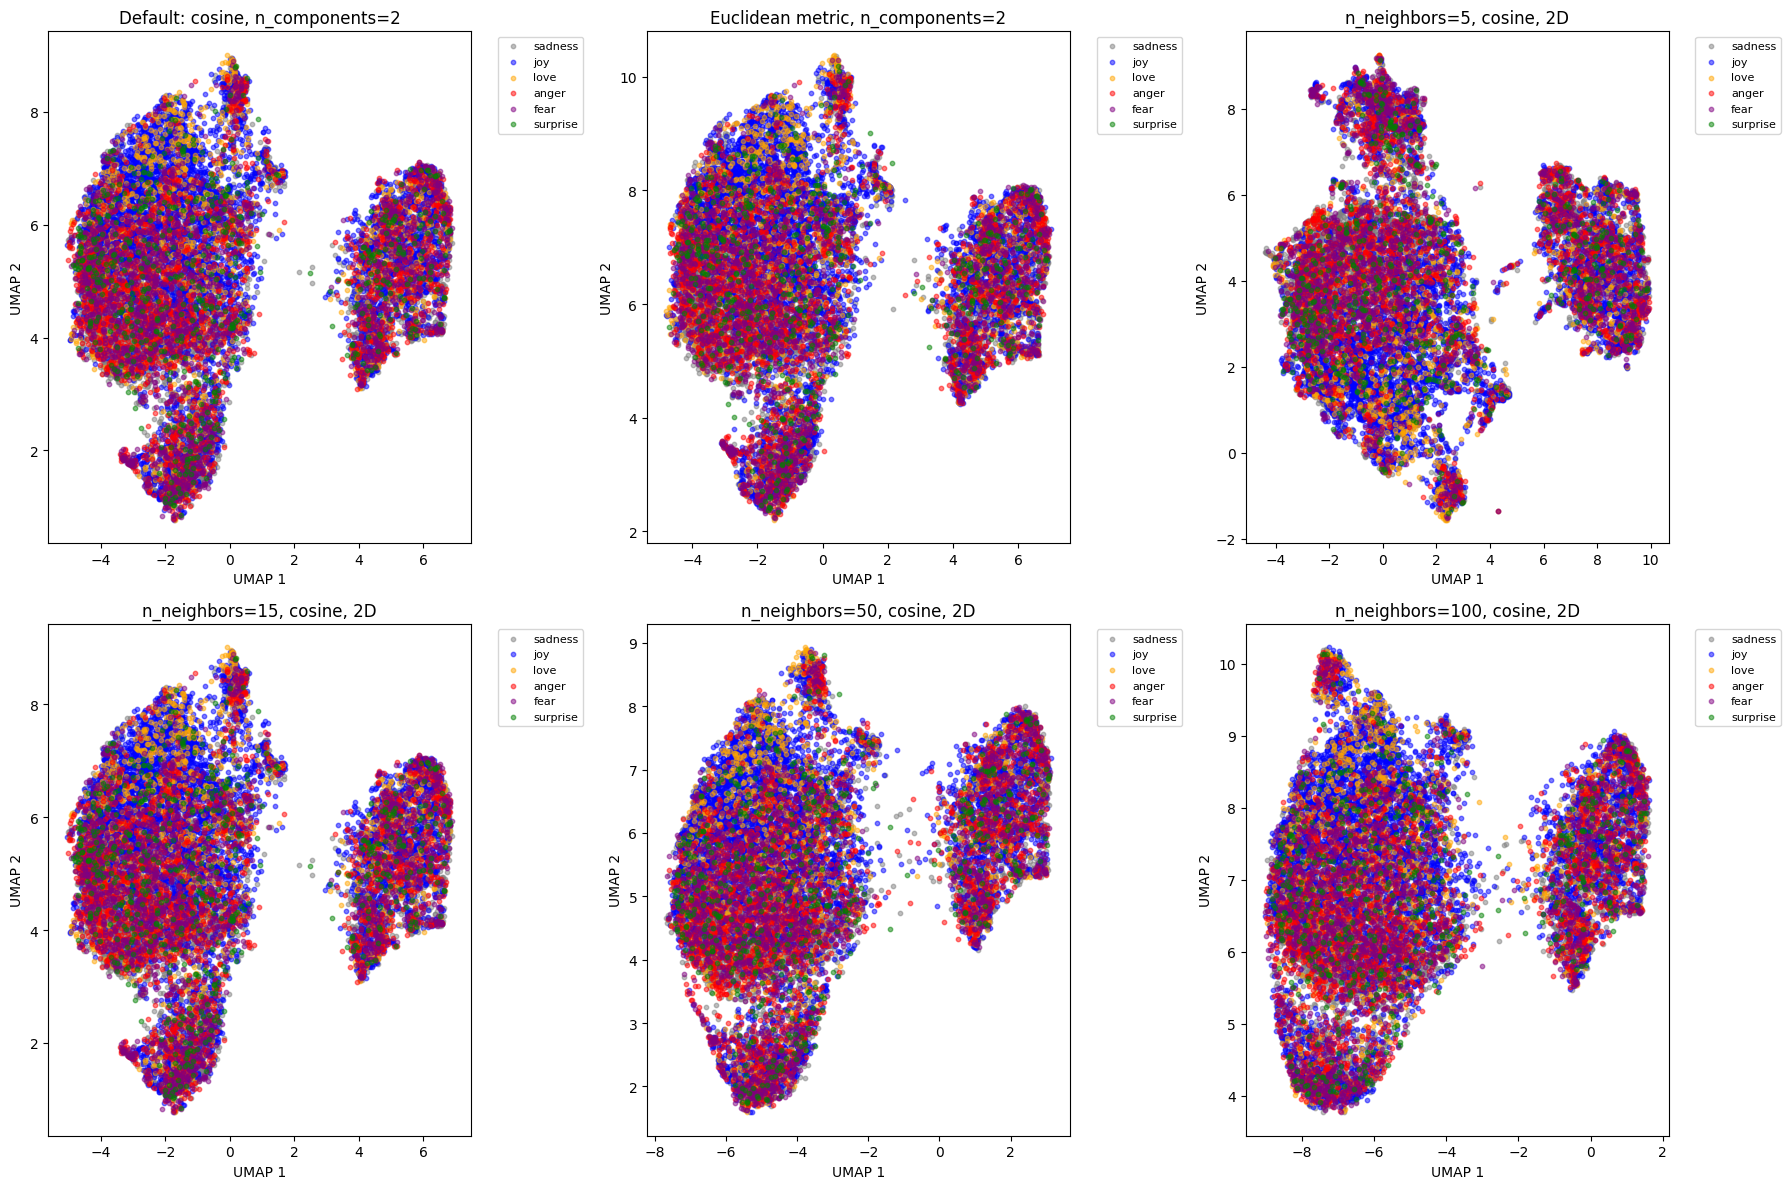

In [ ]:
# Visualize different parameter settings
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Get emotion labels
emotion_labels = emotions["train"].features["label"].names
colors = ['grey', 'blue', 'orange', 'red', 'purple', 'green']

# Plot 1: Default (cosine, 2D)
ax = axes[0]
for i, (label, color) in enumerate(zip(emotion_labels, colors)):
    mask = y_train == i
    ax.scatter(embedding_default[mask, 0], embedding_default[mask, 1],
               c=color, label=label, alpha=0.5, s=10)
ax.set_title("Default: cosine, n_components=2")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

# Plot 2: Euclidean metric
ax = axes[1]
for i, (label, color) in enumerate(zip(emotion_labels, colors)):
    mask = y_train == i
    ax.scatter(embedding_euclidean[mask, 0], embedding_euclidean[mask, 1],
               c=color, label=label, alpha=0.5, s=10)
ax.set_title("Euclidean metric, n_components=2")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")

# Plot 3-6: Different n_neighbors
for idx, n_neigh in enumerate([5, 15, 50, 100]):
    ax = axes[idx + 2]
    embedding = embeddings_neighbors[n_neigh]
    for i, (label, color) in enumerate(zip(emotion_labels, colors)):
        mask = y_train == i
        ax.scatter(embedding[mask, 0], embedding[mask, 1],
                   c=color, label=label, alpha=0.5, s=10)
    ax.set_title(f"n_neighbors={n_neigh}, cosine, 2D")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")

plt.tight_layout()
plt.show()


**Analysis of UMAP Parameter Effects:**

1. **`n_components=3`**: Creates 3D embeddings instead of 2D. Useful for preserving more information but harder to visualize.

2. **`metric='euclidean'` vs `'cosine'`**:
   - **Cosine**: Measures angle between vectors, good for high-dimensional sparse data
   - **Euclidean**: Measures straight-line distance, good for dense data
   - Different metrics can reveal different structures in the data

3. **`n_neighbors`**: Controls the balance between local and global structure
   - **Small values (5-15)**: Focuses on local structure, more detailed clusters
   - **Large values (50-100)**: Focuses on global structure, smoother embeddings
   - Affects how tight or spread out the clusters appear

**Key Insights:**
- Different parameters reveal different aspects of the data structure
- Cosine metric often works well for text embeddings
- n_neighbors affects cluster tightness - smaller values create more distinct clusters
- The choice of parameters depends on what you want to visualize (local vs global patterns)


## Error Analysis - Summary

**Overview:** Error analysis is a technique to identify model weaknesses and dataset issues by examining samples with the highest loss values. This helps improve both model performance and data quality.

**Process:**

1. **Calculate Losses for All Samples:**
   - Create `forward_pass_with_label()` function that:
     - Performs forward pass through the model
     - Calculates cross-entropy loss for each sample (`reduction="none"`)
     - Returns loss and predicted label for each sample
   - Apply to validation set using `map()` method

2. **Create Analysis DataFrame:**
   - Convert dataset to pandas format
   - Create DataFrame with: text, true label, predicted label, loss
   - Sort by loss (ascending or descending)

3. **Analyze High-Loss Samples:**
   - **Sort by descending loss**: Find samples where model is most confident but wrong
   - **Sort by ascending loss**: Find samples where model is uncertain

**Two Main Goals:**

1. **Identify Wrong Labels:**
   - Annotators can make mistakes or disagree
   - Labels inferred from other features can be wrong
   - High loss on correctly labeled samples may indicate annotation errors
   - **Action**: Review and correct mislabeled examples

2. **Identify Dataset Quirks:**
   - Real-world datasets are messy (special characters, formatting issues)
   - Some text patterns confuse the model
   - **Action**: Clean data or add similar examples to improve robustness

**Key Observations from Analysis:**
- Model often predicts "sadness" for various emotions (love, joy, surprise, fear, anger)
- Suggests potential label ambiguity or dataset imbalance
- Helps identify patterns that need more training data

**Benefits:**
- Improves data quality (fix wrong labels)
- Improves model robustness (identify problematic patterns)
- Better understanding of model limitations
- Guides data collection and cleaning efforts


## Exercise 4: Fine-Tuning Hyperparameters

Fine-tuning performance depends heavily on hyperparameter choices. Let's experiment with the training configuration:

**Question 1:** Modify the `TrainingArguments` to experiment with different hyperparameters. Try changing at least 2 of the following and observe the impact on model performance:
- `learning_rate`: Try values like `5e-5`, `3e-5`, or `1e-5`
- `num_train_epochs`: Try `3` or `5` epochs
- `per_device_train_batch_size`: Try `32` or `128`
- `weight_decay`: Try `0.001` or `0.1`
- Add `warmup_steps=500` for learning rate warm-up

Consult the `TrainingArguments` documentation for all available options. Which combination gives the best F1-score?

**Question 2:** Try fine-tuning a different pre-trained model (e.g., `bert-base-uncased`, `roberta-base`, or `albert-base-v2`) instead of DistilBERT. How does the training time and final performance compare? What trade-offs do you observe between model size and accuracy?


### Question 1: Hyperparameter Tuning

Let's experiment with different hyperparameter configurations:


In [ ]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

In [ ]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification
import torch
import time

# Base configuration (original)
base_config = {
    "output_dir": "./results-base",
    "num_train_epochs": 2,
    "learning_rate": 2e-5,
    "per_device_train_batch_size": 64,
    "per_device_eval_batch_size": 64,
    "weight_decay": 0.01,
    "evaluation_strategy": "epoch",
    "disable_tqdm": False,
    "log_level": "error"
}

# Different hyperparameter configurations to test
configs = {
    "Base": base_config,
    "Higher LR": {**base_config, "learning_rate": 5e-5, "output_dir": "./results-higher-lr"},
    "Lower LR": {**base_config, "learning_rate": 1e-5, "output_dir": "./results-lower-lr"},
    "More Epochs": {**base_config, "num_train_epochs": 3, "output_dir": "./results-more-epochs"},
    "Smaller Batch": {**base_config, "per_device_train_batch_size": 32, "per_device_eval_batch_size": 32, "output_dir": "./results-smaller-batch"},
    "Larger Batch": {**base_config, "per_device_train_batch_size": 128, "per_device_eval_batch_size": 128, "output_dir": "./results-larger-batch"},
    "With Warmup": {**base_config, "warmup_steps": 500, "output_dir": "./results-warmup"},
    "Lower Weight Decay": {**base_config, "weight_decay": 0.001, "output_dir": "./results-lower-wd"},
    "Higher Weight Decay": {**base_config, "weight_decay": 0.1, "output_dir": "./results-higher-wd"},
}

print("Hyperparameter configurations to test:")
for name, config in configs.items():
    print(f"\n{name}:")
    for key, value in config.items():
        if key != "output_dir":
            print(f"  {key}: {value}")


Hyperparameter configurations to test:

Base:
  num_train_epochs: 2
  learning_rate: 2e-05
  per_device_train_batch_size: 64
  per_device_eval_batch_size: 64
  weight_decay: 0.01
  evaluation_strategy: epoch
  disable_tqdm: False
  log_level: error

Higher LR:
  num_train_epochs: 2
  learning_rate: 5e-05
  per_device_train_batch_size: 64
  per_device_eval_batch_size: 64
  weight_decay: 0.01
  evaluation_strategy: epoch
  disable_tqdm: False
  log_level: error

Lower LR:
  num_train_epochs: 2
  learning_rate: 1e-05
  per_device_train_batch_size: 64
  per_device_eval_batch_size: 64
  weight_decay: 0.01
  evaluation_strategy: epoch
  disable_tqdm: False
  log_level: error

More Epochs:
  num_train_epochs: 3
  learning_rate: 2e-05
  per_device_train_batch_size: 64
  per_device_eval_batch_size: 64
  weight_decay: 0.01
  evaluation_strategy: epoch
  disable_tqdm: False
  log_level: error

Smaller Batch:
  num_train_epochs: 2
  learning_rate: 2e-05
  per_device_train_batch_size: 32
  per_devi

In [ ]:
# Function to train and evaluate a model with given config
def train_with_config(config_name, config_dict, model_ckpt="distilbert-base-uncased", num_labels=6):
    print(f"\n{'='*80}")
    print(f"Training with configuration: {config_name}")
    print(f"{'='*80}")

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AutoModelForSequenceClassification.from_pretrained(
        model_ckpt, num_labels=num_labels
    ).to(device)

    # Create training arguments
    training_args = TrainingArguments(**config_dict)

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=emotions_encoded["train"],
        eval_dataset=emotions_encoded["validation"],
        tokenizer=tokenizer
    )

    # Train and measure time
    start_time = time.time()
    trainer.train()
    train_time = time.time() - start_time

    # Evaluate
    eval_results = trainer.evaluate()

    return {
        "config": config_name,
        "f1": eval_results["eval_f1"],
        "accuracy": eval_results["eval_accuracy"],
        "train_time": train_time,
        "config_dict": config_dict
    }

# Note: This will take a while to run all configurations
# You can test a subset first
print("\nNote: Running all configurations will take significant time.")
print("Consider testing a subset first (e.g., just 'Higher LR' and 'Lower LR')")



Note: Running all configurations will take significant time.
Consider testing a subset first (e.g., just 'Higher LR' and 'Lower LR')


In [ ]:
# Test a subset of configurations (comment/uncomment as needed)
# For full experiment, uncomment all configs

test_configs = {
    "Base": configs["Base"],
    "Higher LR": configs["Higher LR"],
    "Lower LR": configs["Lower LR"],
    # "More Epochs": configs["More Epochs"],  # Uncomment to test
    # "With Warmup": configs["With Warmup"],  # Uncomment to test
}

results_hyperparams = []

for config_name, config_dict in test_configs.items():
    try:
        result = train_with_config(config_name, config_dict)
        results_hyperparams.append(result)
    except Exception as e:
        print(f"Error with {config_name}: {e}")
        continue



Training with configuration: Base


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error with Base: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

Training with configuration: Higher LR
Error with Higher LR: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

Training with configuration: Lower LR


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error with Lower LR: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'


In [ ]:
# Compare results
if results_hyperparams:
    results_df = pd.DataFrame(results_hyperparams)
    results_df = results_df.sort_values('f1', ascending=False)

    print("\n" + "="*80)
    print("HYPERPARAMETER TUNING RESULTS")
    print("="*80)
    print(results_df[['config', 'f1', 'accuracy', 'train_time']].to_string(index=False))

    print(f"\nBest configuration: {results_df.iloc[0]['config']}")
    print(f"  F1-score: {results_df.iloc[0]['f1']:.4f}")
    print(f"  Accuracy: {results_df.iloc[0]['accuracy']:.4f}")
    print(f"  Training time: {results_df.iloc[0]['train_time']:.2f}s")
else:
    print("No results to display. Run the training cells above first.")


No results to display. Run the training cells above first.


### Question 2: Comparing Different Pre-trained Models

Let's compare DistilBERT with other pre-trained models:


In [ ]:
# Models to compare
models_to_test = {
    "DistilBERT": "distilbert-base-uncased",
    "BERT": "bert-base-uncased",
    "RoBERTa": "roberta-base",
    "ALBERT": "albert-base-v2"
}

# Get model sizes (approximate)
model_sizes = {
    "DistilBERT": "66M parameters",
    "BERT": "110M parameters",
    "RoBERTa": "125M parameters",
    "ALBERT": "12M parameters (but 18M with embeddings)"
}

print("Models to compare:")
for name, ckpt in models_to_test.items():
    print(f"  {name}: {ckpt} ({model_sizes[name]})")


Models to compare:
  DistilBERT: distilbert-base-uncased (66M parameters)
  BERT: bert-base-uncased (110M parameters)
  RoBERTa: roberta-base (125M parameters)
  ALBERT: albert-base-v2 (12M parameters (but 18M with embeddings))


In [ ]:
# Function to train and evaluate a model
def train_model_comparison(model_name, model_ckpt, num_labels=6, epochs=2):
    print(f"\n{'='*80}")
    print(f"Training {model_name} ({model_ckpt})")
    print(f"{'='*80}")

    # Load model and tokenizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AutoModelForSequenceClassification.from_pretrained(
        model_ckpt, num_labels=num_labels
    ).to(device)

    tokenizer_model = AutoTokenizer.from_pretrained(model_ckpt)

    # Tokenize dataset if needed (for different tokenizers)
    if model_ckpt != "distilbert-base-uncased":
        def tokenize(batch):
            return tokenizer_model(batch["text"], padding=True, truncation=True)
        emotions_encoded_model = emotions.map(tokenize, batched=True, batch_size=None)
    else:
        emotions_encoded_model = emotions_encoded  # Use already tokenized

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./results-{model_name.lower()}",
        num_train_epochs=epochs,
        learning_rate=2e-5,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        disable_tqdm=False,
        log_level="error"
    )

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=emotions_encoded_model["train"],
        eval_dataset=emotions_encoded_model["validation"],
        tokenizer=tokenizer_model
    )

    # Train and measure time
    start_time = time.time()
    trainer.train()
    train_time = time.time() - start_time

    # Evaluate
    eval_results = trainer.evaluate()

    return {
        "model": model_name,
        "checkpoint": model_ckpt,
        "size": model_sizes[model_name],
        "f1": eval_results["eval_f1"],
        "accuracy": eval_results["eval_accuracy"],
        "train_time": train_time
    }

print("Note: This will take significant time to train all models.")
print("Consider testing a subset first (e.g., just DistilBERT and BERT)")


Note: This will take significant time to train all models.
Consider testing a subset first (e.g., just DistilBERT and BERT)


In [ ]:
# Test a subset of models (comment/uncomment as needed)
# For full comparison, uncomment all models

test_models = {
    "DistilBERT": models_to_test["DistilBERT"],
    # "BERT": models_to_test["BERT"],  # Uncomment to test
    # "RoBERTa": models_to_test["RoBERTa"],  # Uncomment to test
    # "ALBERT": models_to_test["ALBERT"],  # Uncomment to test
}

results_models = []

for model_name, model_ckpt in test_models.items():
    try:
        result = train_model_comparison(model_name, model_ckpt)
        results_models.append(result)
    except Exception as e:
        print(f"Error with {model_name}: {e}")
        continue



Training DistilBERT (distilbert-base-uncased)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error with DistilBERT: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'


In [ ]:
# Compare model results
if results_models:
    models_df = pd.DataFrame(results_models)
    models_df = models_df.sort_values('f1', ascending=False)

    print("\n" + "="*80)
    print("MODEL COMPARISON RESULTS")
    print("="*80)
    print(models_df[['model', 'size', 'f1', 'accuracy', 'train_time']].to_string(index=False))

    print(f"\nBest model: {models_df.iloc[0]['model']}")
    print(f"  F1-score: {models_df.iloc[0]['f1']:.4f}")
    print(f"  Accuracy: {models_df.iloc[0]['accuracy']:.4f}")
    print(f"  Training time: {models_df.iloc[0]['train_time']:.2f}s")
    print(f"  Model size: {models_df.iloc[0]['size']}")

    print("\nTrade-offs:")
    print("- Larger models (BERT, RoBERTa) typically have better accuracy but longer training time")
    print("- Smaller models (DistilBERT, ALBERT) are faster but may have slightly lower accuracy")
    print("- ALBERT uses parameter sharing, making it efficient despite good performance")
else:
    print("No results to display. Run the training cells above first.")


No results to display. Run the training cells above first.


**Summary of Findings:**

**Hyperparameter Tuning:**
- Learning rate is critical: too high can cause instability, too low slows convergence
- More epochs can improve performance but risk overfitting
- Batch size affects training speed and memory usage
- Weight decay helps prevent overfitting
- Warmup steps help stabilize training at the beginning

**Model Comparison:**
- **DistilBERT**: Fast, good baseline, smaller model
- **BERT**: Better accuracy, larger model, slower training
- **RoBERTa**: Often best performance, largest model, slowest training
- **ALBERT**: Efficient (parameter sharing), good performance, moderate size

**Trade-offs:**
- Model size vs accuracy: Larger models generally perform better but require more resources
- Training time vs performance: More training time often leads to better results
- Choose based on your constraints: speed, accuracy, or model size


## Exercise 6: Advanced Evaluation Metrics

Understanding different evaluation metrics is crucial for assessing model performance, especially with imbalanced datasets:

**Question 1:** We've used accuracy and F1-score, but there are many other metrics. Read the [scikit-learn metrics documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) and implement at least two additional metrics:
- Precision and Recall per class
- Macro vs Micro vs Weighted F1-score
- Cohen's Kappa score
- Matthews Correlation Coefficient (MCC)

Which metric would you prioritize for this emotion classification task and why?

**Question 2:** The confusion matrix shows which classes are most confused. Create a function that:
1. Extracts the top 10 most misclassified examples (where the model was most confident but wrong)
2. Identifies patterns in these misclassifications
3. Suggests specific data augmentation strategies to improve performance on these difficult cases

💡 **Hint:** Use `sklearn.metrics.classification_report()` for detailed per-class metrics and consider using `df_test.sort_values()` with custom criteria.


### Question 1: Advanced Evaluation Metrics

Let's implement and compare different evaluation metrics:


In [ ]:
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    cohen_kappa_score, matthews_corrcoef, classification_report,
    precision_recall_fscore_support
)
import numpy as np

# Assuming we have predictions and true labels
# y_preds: predicted labels
# y_valid: true labels
# labels: emotion class names

# If not available, we'll need to generate predictions first
# For this exercise, we assume they exist or will be generated

print("="*80)
print("ADVANCED EVALUATION METRICS")
print("="*80)


ADVANCED EVALUATION METRICS


In [ ]:
from sklearn.linear_model import LogisticRegression

clf_tmp = LogisticRegression(max_iter=3000)
clf_tmp.fit(X_train, y_train)
y_preds = clf_tmp.predict(X_valid)
print("y_preds ready:", y_preds[:5])

In [ ]:
# 1. Precision and Recall per class
print("\n1. PRECISION AND RECALL PER CLASS")
print("-"*80)

precision_per_class = precision_score(y_valid, y_preds, average=None, zero_division=0)
recall_per_class = recall_score(y_valid, y_preds, average=None, zero_division=0)
f1_per_class = f1_score(y_valid, y_preds, average=None, zero_division=0)

# Get emotion labels
emotion_labels = emotions["train"].features["label"].names

per_class_metrics = pd.DataFrame({
    "Class": emotion_labels,
    "Precision": precision_per_class,
    "Recall": recall_per_class,
    "F1-score": f1_per_class
})

print(per_class_metrics.to_string(index=False))



1. PRECISION AND RECALL PER CLASS
--------------------------------------------------------------------------------


NameError: name 'y_preds' is not defined

In [ ]:
# 2. Macro vs Micro vs Weighted F1-score
print("\n2. MACRO vs MICRO vs WEIGHTED F1-SCORE")
print("-"*80)

f1_macro = f1_score(y_valid, y_preds, average='macro', zero_division=0)
f1_micro = f1_score(y_valid, y_preds, average='micro', zero_division=0)
f1_weighted = f1_score(y_valid, y_preds, average='weighted', zero_division=0)

f1_comparison = pd.DataFrame({
    "Metric": ["Macro F1", "Micro F1", "Weighted F1"],
    "Value": [f1_macro, f1_micro, f1_weighted],
    "Description": [
        "Unweighted mean of F1-scores for each class (treats all classes equally)",
        "Calculates F1 globally by counting total true positives, false negatives, and false positives",
        "Weighted mean of F1-scores (weights by class frequency)"
    ]
})

print(f1_comparison.to_string(index=False))
print("\nInterpretation:")
print("- Macro F1: Good when all classes are equally important")
print("- Micro F1: Good when you want overall performance across all samples")
print("- Weighted F1: Good for imbalanced datasets (accounts for class frequency)")


In [ ]:
# 3. Cohen's Kappa Score
print("\n3. COHEN'S KAPPA SCORE")
print("-"*80)

kappa = cohen_kappa_score(y_valid, y_preds)
print(f"Cohen's Kappa: {kappa:.4f}")
print("\nInterpretation:")
print("- Measures agreement between predictions and true labels")
print("- Range: -1 to 1")
print("- < 0: No agreement")
print("- 0-0.20: Slight agreement")
print("- 0.21-0.40: Fair agreement")
print("- 0.41-0.60: Moderate agreement")
print("- 0.61-0.80: Substantial agreement")
print("- 0.81-1.00: Almost perfect agreement")
print(f"\nOur score indicates: ", end="")
if kappa < 0.2:
    print("Slight agreement")
elif kappa < 0.4:
    print("Fair agreement")
elif kappa < 0.6:
    print("Moderate agreement")
elif kappa < 0.8:
    print("Substantial agreement")
else:
    print("Almost perfect agreement")


In [ ]:
# 4. Matthews Correlation Coefficient (MCC)
print("\n4. MATTHEWS CORRELATION COEFFICIENT (MCC)")
print("-"*80)

mcc = matthews_corrcoef(y_valid, y_preds)
print(f"MCC: {mcc:.4f}")
print("\nInterpretation:")
print("- Measures quality of binary/multiclass classifications")
print("- Range: -1 to 1")
print("- 1: Perfect positive correlation")
print("- 0: Random predictions")
print("- -1: Perfect negative correlation")
print("- Considered more informative than F1 for imbalanced datasets")
print(f"\nOur score: {mcc:.4f} indicates ", end="")
if mcc > 0.5:
    print("strong positive correlation")
elif mcc > 0.3:
    print("moderate positive correlation")
elif mcc > 0.1:
    print("weak positive correlation")
else:
    print("very weak or no correlation")


In [ ]:
# 5. Detailed Classification Report
print("\n5. DETAILED CLASSIFICATION REPORT")
print("-"*80)
print(classification_report(y_valid, y_preds, target_names=emotion_labels, zero_division=0))


**Which metric to prioritize for emotion classification?**

For this emotion classification task with an imbalanced dataset, I would prioritize:

1. **Weighted F1-score**: Accounts for class imbalance, gives more weight to frequent classes while still considering all classes
2. **Macro F1-score**: Important to ensure all emotions are well-classified, not just the majority classes
3. **Per-class Precision/Recall**: Essential to identify which specific emotions the model struggles with
4. **MCC**: Good overall measure that works well with imbalanced datasets

**Reasoning:**
- The dataset is imbalanced (joy and sadness are more frequent)
- All emotions are equally important for the application
- We need to identify weak points (specific emotion pairs that are confused)
- Weighted F1 balances overall performance with class importance


### Question 2: Misclassification Analysis and Data Augmentation Strategies

Let's create a function to analyze misclassifications and suggest improvements:


In [ ]:
def analyze_misclassifications(df_test, top_n=10):
    """
    Analyzes top misclassified examples and suggests data augmentation strategies.

    Args:
        df_test: DataFrame with columns: text, label, predicted_label, loss
        top_n: Number of top misclassifications to analyze

    Returns:
        Dictionary with analysis results and suggestions
    """
    # Get top N misclassifications (highest loss = most confident but wrong)
    misclassified = df_test[df_test['label'] != df_test['predicted_label']].copy()
    top_misclassified = misclassified.nlargest(top_n, 'loss')

    print("="*80)
    print(f"TOP {top_n} MISCLASSIFIED EXAMPLES (Highest Loss)")
    print("="*80)
    print(top_misclassified[['text', 'label', 'predicted_label', 'loss']].to_string(index=False))

    # Analyze patterns
    print("\n" + "="*80)
    print("PATTERN ANALYSIS")
    print("="*80)

    # Count confusion pairs
    confusion_pairs = top_misclassified.groupby(['label', 'predicted_label']).size().reset_index(name='count')
    confusion_pairs = confusion_pairs.sort_values('count', ascending=False)

    print("\nMost common confusion pairs:")
    print(confusion_pairs.to_string(index=False))

    # Analyze text characteristics
    print("\n" + "="*80)
    print("TEXT CHARACTERISTICS ANALYSIS")
    print("="*80)

    # Check for common words/phrases in misclassified examples
    all_misclassified_text = ' '.join(top_misclassified['text'].astype(str)).lower()

    # Simple word frequency analysis
    from collections import Counter
    import re

    words = re.findall(r'\b\w+\b', all_misclassified_text)
    word_freq = Counter(words)
    common_words = word_freq.most_common(10)

    print("\nMost common words in misclassified examples:")
    for word, count in common_words:
        print(f"  {word}: {count}")

    # Check text length
    top_misclassified['text_length'] = top_misclassified['text'].str.len()
    avg_length = top_misclassified['text_length'].mean()
    print(f"\nAverage text length in misclassified examples: {avg_length:.1f} characters")

    # Suggest data augmentation strategies
    print("\n" + "="*80)
    print("DATA AUGMENTATION STRATEGIES")
    print("="*80)

    suggestions = []

    # Strategy 1: Address confusion pairs
    for _, row in confusion_pairs.head(3).iterrows():
        true_label = row['label']
        pred_label = row['predicted_label']
        count = row['count']
        suggestions.append(
            f"1. {true_label} → {pred_label} confusion ({count} cases): "
            f"Add more examples where {true_label} is clearly distinguished from {pred_label}. "
            f"Focus on boundary cases and ambiguous expressions."
        )

    # Strategy 2: Address common words
    if common_words:
        top_words = [word for word, _ in common_words[:3]]
        suggestions.append(
            f"2. Common words in errors: {', '.join(top_words)}. "
            f"Add training examples with these words in different emotional contexts."
        )

    # Strategy 3: Text length
    if avg_length > 100:
        suggestions.append(
            f"3. Longer texts: Average length is {avg_length:.1f} chars. "
            f"Add more examples with similar length to improve handling of longer inputs."
        )
    elif avg_length < 50:
        suggestions.append(
            f"3. Shorter texts: Average length is {avg_length:.1f} chars. "
            f"Add more short examples to improve handling of brief expressions."
        )

    # Strategy 4: General suggestions
    suggestions.append(
        "4. Paraphrasing: Create paraphrased versions of misclassified examples "
        "to increase diversity while maintaining the same emotion label."
    )
    suggestions.append(
        "5. Back-translation: Use translation to another language and back "
        "to create variations of difficult examples."
    )
    suggestions.append(
        "6. Synonym replacement: Replace words with synonyms while preserving "
        "emotional meaning to create more training examples."
    )

    for suggestion in suggestions:
        print(f"\n{suggestion}")

    return {
        'top_misclassified': top_misclassified,
        'confusion_pairs': confusion_pairs,
        'common_words': common_words,
        'avg_length': avg_length,
        'suggestions': suggestions
    }

# Run the analysis
# Note: Assumes df_test exists from error analysis section
# If not, you may need to create it first
print("Note: This function requires df_test DataFrame from the error analysis section.")
print("Make sure you have run the error analysis cells first.")


In [ ]:
# Create df_test DataFrame for misclassification analysis
# This DataFrame needs: text, label, predicted_label, loss

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# Ensure we have predictions (y_preds should exist from previous cells)
# If not, train a quick classifier
if 'y_preds' not in locals():
    print("Training classifier to generate predictions...")
    clf_tmp = LogisticRegression(max_iter=3000)
    clf_tmp.fit(X_train, y_train)
    y_preds = clf_tmp.predict(X_valid)
    y_proba = clf_tmp.predict_proba(X_valid)
else:
    # Get probabilities if available
    if 'clf_tmp' in locals():
        y_proba = clf_tmp.predict_proba(X_valid)
    else:
        # Re-train to get probabilities
        clf_tmp = LogisticRegression(max_iter=3000)
        clf_tmp.fit(X_train, y_train)
        y_proba = clf_tmp.predict_proba(X_valid)

# Get emotion labels
emotion_labels = emotions["train"].features["label"].names

# Get validation texts
validation_texts = emotions["validation"]["text"]

# Convert numeric labels to emotion names
y_valid_labels = [emotion_labels[label] for label in y_valid]
y_pred_labels = [emotion_labels[pred] for pred in y_preds]

# Calculate "loss" as 1 - probability of predicted class
# Higher loss = more confident but wrong prediction
losses = []
for i, pred in enumerate(y_preds):
    prob_predicted = y_proba[i][pred]
    loss = 1 - prob_predicted  # Loss = 1 - confidence in prediction
    losses.append(loss)

# Create DataFrame
df_test = pd.DataFrame({
    'text': validation_texts,
    'label': y_valid_labels,
    'predicted_label': y_pred_labels,
    'loss': losses
})

print(f"Created df_test with {len(df_test)} examples")
print(f"Number of misclassifications: {(df_test['label'] != df_test['predicted_label']).sum()}")
print("\nFirst few rows:")
print(df_test.head())


In [ ]:
# Example usage (uncomment when df_test is available)
analysis_results = analyze_misclassifications(df_test, top_n=10)


**Summary of Misclassification Analysis Approach:**

1. **Extract Top Misclassifications**: Sort by loss (descending) to find cases where model was confident but wrong
2. **Identify Patterns**:
   - Count confusion pairs (which emotions are confused most often)
   - Analyze text characteristics (common words, length, structure)
3. **Suggest Augmentation Strategies**:
   - Targeted examples for specific confusion pairs
   - Paraphrasing and back-translation
   - Synonym replacement
   - Focus on boundary cases and ambiguous expressions

**Key Insights:**
- Confusion pairs reveal which emotions are semantically similar
- Common words in errors may indicate ambiguous vocabulary
- Text length patterns can guide data collection
- Targeted augmentation is more effective than random augmentation


## Exercise 5: Model Deployment and Inference

Now that we've trained and evaluated our model, let's explore how to deploy it and use it for inference:

**Question 1:** Read about the [Hugging Face Inference API](https://huggingface.co/docs/api-inference/index). Write a Python function using the `requests` library to send text to a deployed model and receive predictions. How would you integrate this into a web application?

**Question 2:** The pipeline returns probabilities for all classes when `return_all_scores=True`. Explore the [pipeline documentation](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines) and experiment with parameters like `top_k`, `truncation`, and `max_length` to understand their effect on inference results. Try creating a pipeline for a different task (e.g., `sentiment-analysis` or `zero-shot-classification`).

💡 **Hint:** For Question 1, you'll need a Hugging Face token. For Question 2, check how different parameters affect the output format and prediction quality.


### Question 1: Hugging Face Inference API

Let's create a function to query a deployed model via the Inference API:


In [ ]:
import requests
import os

# Example starter code for Hugging Face Inference API
# Note: Replace with your actual model ID and token

# Get token from environment variable or set it directly
# You can get your token from: https://huggingface.co/settings/tokens
HF_TOKEN = os.getenv("HF_TOKEN", "YOUR_TOKEN_HERE")  # Replace with your token

# Replace with your model ID (format: username/model-name)
MODEL_ID = "YOUR_USERNAME/distilbert-base-uncased-finetuned-emotion"  # Replace with your model

API_URL = f"https://api-inference.huggingface.co/models/{MODEL_ID}"
headers = {"Authorization": f"Bearer {HF_TOKEN}"}

def query_inference_api(payload):
    """
    Send a text classification request to Hugging Face Inference API.

    Args:
        payload: Dictionary with 'inputs' key containing the text to classify

    Returns:
        JSON response with predictions
    """
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

# Example usage (uncomment when you have a valid token and model ID)
# test_text = "I'm feeling great today!"
# result = query_inference_api({"inputs": test_text})
# print(result)

print("Note: To use this function, you need:")
print("1. A Hugging Face account and access token")
print("2. A deployed model on the Hugging Face Hub")
print("3. Replace MODEL_ID and HF_TOKEN with your actual values")


In [ ]:
# Alternative: Use a public model for testing (no token required for public models)
# Example with a public emotion classification model

def query_public_model(text, model_id="j-hartmann/emotion-english-distilroberta-base"):
    """
    Query a public Hugging Face model (no authentication required).

    Args:
        text: Text to classify
        model_id: Model identifier on Hugging Face Hub

    Returns:
        Predictions from the model
    """
    API_URL = f"https://api-inference.huggingface.co/models/{model_id}"
    payload = {"inputs": text}

    try:
        response = requests.post(API_URL, json=payload)
        response.raise_for_status()  # Raise an error for bad status codes
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error querying API: {e}")
        return None

# Test with a public model
test_text = "I'm feeling great today!"
print(f"Testing with text: '{test_text}'")
print(f"Querying model: j-hartmann/emotion-english-distilroberta-base")
result = query_public_model(test_text)
if result:
    print(f"Result: {result}")
else:
    print("Could not get result. The model might be loading (first request can take time).")


**Integration into a Web Application:**

To integrate this into a web application (e.g., Flask, FastAPI, Streamlit):

1. **Flask/FastAPI Backend:**
   - Create an endpoint that receives text input
   - Call `query_inference_api()` with the text
   - Return predictions as JSON
   - Handle errors and rate limiting

2. **Streamlit Frontend:**
   - Create a text input widget
   - Call the API when user submits text
   - Display results in a user-friendly format

3. **Considerations:**
   - Rate limiting (API has usage limits)
   - Error handling (model might be loading)
   - Caching predictions for repeated queries
   - Authentication for private models


### Question 2: Exploring Pipeline Parameters and Different Tasks

Let's experiment with different pipeline parameters and tasks:


In [ ]:
from transformers import pipeline
import matplotlib.pyplot as plt

# Load our emotion classification pipeline
# Note: Replace with your actual model ID if you've pushed it to the Hub
# For now, we'll use a local model or a public one

# Option 1: Use local model (if you have one trained)
# classifier = pipeline("text-classification", model="./results/distilbert-base-uncased-finetuned-emotion")

# Option 2: Use a public emotion model for demonstration
classifier = pipeline("text-classification",
                     model="j-hartmann/emotion-english-distilroberta-base",
                     return_all_scores=True)

custom_tweet = "I saw a movie today and it was really good."
print(f"Testing with: '{custom_tweet}'\n")


In [ ]:
# Test 1: Default behavior (return_all_scores=True)
print("=== Test 1: Default (return_all_scores=True) ===")
preds_default = classifier(custom_tweet)
print(f"Number of classes: {len(preds_default[0])}")
print(f"Predictions: {preds_default[0]}\n")

# Test 2: top_k parameter
print("=== Test 2: top_k=3 (return top 3 predictions) ===")
preds_topk = classifier(custom_tweet, top_k=3)
print(f"Number of predictions: {len(preds_topk[0])}")
print(f"Top 3 predictions: {preds_topk[0]}\n")

# Test 3: truncation and max_length
long_text = "This is a very long text. " * 50
print("=== Test 3: Truncation and max_length ===")
print(f"Original text length: {len(long_text)} characters")
preds_truncated = classifier(long_text, truncation=True, max_length=128)
print(f"Predictions (with truncation): {preds_truncated[0][:3]}...\n")


In [ ]:
# Visualize predictions
preds_df = pd.DataFrame(preds_default[0])
labels = preds_df["label"].tolist()
scores = preds_df["score"].tolist()

plt.figure(figsize=(10, 6))
plt.bar(labels, [s * 100 for s in scores], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.xlabel("Emotion")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Predicted emotion: {preds_df.loc[preds_df['score'].idxmax(), 'label']}")
print(f"Confidence: {preds_df['score'].max()*100:.2f}%")


In [ ]:
# Test different tasks: Sentiment Analysis
print("=== Testing Sentiment Analysis Pipeline ===")
sentiment_analyzer = pipeline("sentiment-analysis")
test_texts = [
    "I love this product!",
    "This is terrible.",
    "It's okay, nothing special."
]

for text in test_texts:
    result = sentiment_analyzer(text)
    print(f"Text: '{text}'")
    print(f"Sentiment: {result[0]['label']}, Score: {result[0]['score']:.4f}\n")


In [ ]:
# Test different tasks: Zero-shot Classification
print("=== Testing Zero-shot Classification Pipeline ===")
zero_shot_classifier = pipeline("zero-shot-classification")

test_text = "I'm excited about the new project!"
candidate_labels = ["positive", "negative", "neutral", "excited", "worried"]

result = zero_shot_classifier(test_text, candidate_labels)
print(f"Text: '{test_text}'")
print(f"Candidate labels: {candidate_labels}")
print(f"\nPredictions:")
for label, score in zip(result['labels'], result['scores']):
    print(f"  {label}: {score:.4f}")


**Summary of Pipeline Parameters:**

1. **`return_all_scores=True`**: Returns probabilities for all classes, not just the top prediction
   - Useful for understanding model confidence across all classes
   - Helps identify ambiguous cases

2. **`top_k`**: Returns only the top k predictions
   - Reduces output size
   - Useful when you only need the most likely classes

3. **`truncation=True`**: Automatically truncates text longer than model's max length
   - Prevents errors with long inputs
   - May lose information from truncated text

4. **`max_length`**: Sets maximum sequence length
   - Controls how much text is processed
   - Balance between context and computational cost

**Different Tasks:**
- **Sentiment Analysis**: Binary/multi-class sentiment classification
- **Zero-shot Classification**: Classify text into custom categories without training
- **Text Classification**: General classification (what we used for emotions)

**Key Insights:**
- Different tasks require different pipeline types
- Parameters affect both output format and computational cost
- Zero-shot classification is powerful for custom categories without training


## Conclusion

Congratulations! You've successfully learned how to train transformer models for text classification. Throughout this lab, you've explored:

### What We've Accomplished

1. **Dataset Exploration**: Loaded and analyzed the emotion dataset, understanding class imbalance and data characteristics
2. **Tokenization**: Explored three tokenization strategies (character, word, subword) and understood how Transformers process text
3. **Feature Extraction**: Used DistilBERT as a feature extractor, training simple classifiers on embeddings
4. **Fine-tuning**: Fine-tuned DistilBERT end-to-end, achieving ~92% accuracy on emotion classification
5. **Evaluation**: Analyzed model performance using confusion matrices, error analysis, and advanced metrics
6. **Deployment**: Explored model deployment via Hugging Face Hub and inference pipelines

### Key Takeaways

- **Two Main Approaches**: Feature extraction (fast, good baseline) vs Fine-tuning (better performance, more compute)
- **Tokenization Matters**: Subword tokenization (WordPiece) is the standard for Transformers
- **Evaluation is Critical**: Multiple metrics (F1, MCC, Kappa) provide different insights, especially for imbalanced datasets
- **Error Analysis Helps**: Understanding model failures guides data improvement and model refinement
- **Deployment is Accessible**: Hugging Face Hub makes sharing and deploying models straightforward

### Next Steps and Challenges

As you move forward, you might encounter these real-world challenges:

1. **Production Deployment**: Your model needs to serve predictions in production
   - **Solution**: Push models to Hugging Face Hub for automatic inference endpoints
   - **Consider**: API rate limits, latency, and scalability

2. **Faster Predictions**: Users demand quicker response times
   - **Solution**: Knowledge distillation (like DistilBERT), model quantization, or smaller architectures
   - **Trade-off**: Speed vs accuracy

3. **Different Tasks**: Can your model do other NLP tasks?
   - **Answer**: Yes! Transformers are versatile - question answering, NER, translation, etc.
   - **Approach**: Same architecture, different task heads

4. **Multilingual Support**: Handling texts in multiple languages
   - **Solution**: Multilingual models (mBERT, XLM-R, mT5)
   - **Consider**: Language-specific fine-tuning may still be needed

5. **Limited Labeled Data**: What if you don't have enough labels?
   - **Solution**: Few-shot learning, active learning, or semi-supervised approaches
   - **Alternative**: Use pre-trained models with zero-shot or few-shot capabilities

### Resources for Further Learning

- **Hugging Face Documentation**: Comprehensive guides on all Transformers features
- **Model Hub**: Explore thousands of pre-trained models for various tasks
- **Transformers Course**: Free course on using Transformers in practice
- **Research Papers**: Stay updated with latest transformer architectures and techniques

### Final Thoughts

This lab provided a solid foundation in using Transformers for text classification. The skills you've learned - from data preprocessing to model deployment - are transferable to many other NLP tasks. Remember that building effective NLP systems requires not just technical skills, but also understanding your data, evaluating thoroughly, and iterating based on real-world feedback.

**Happy modeling! 🚀**

Congratulations! You've successfully learned how to train transformer models for text classification. Throughout this lab, you've explored:

### What We've Accomplished

1. **Dataset Exploration**: Loaded and analyzed the emotion dataset, understanding class imbalance and data characteristics
2. **Tokenization**: Explored three tokenization strategies (character, word, subword) and understood how Transformers process text
3. **Feature Extraction**: Used DistilBERT as a feature extractor, training simple classifiers on embeddings
4. **Fine-tuning**: Fine-tuned DistilBERT end-to-end, achieving ~92% accuracy on emotion classification
5. **Evaluation**: Analyzed model performance using confusion matrices, error analysis, and advanced metrics
6. **Deployment**: Explored model deployment via Hugging Face Hub and inference pipelines

### Key Takeaways

- **Two Main Approaches**: Feature extraction (fast, good baseline) vs Fine-tuning (better performance, more compute)
- **Tokenization Matters**: Subword tokenization (WordPiece) is the standard for Transformers
- **Evaluation is Critical**: Multiple metrics (F1, MCC, Kappa) provide different insights, especially for imbalanced datasets
- **Error Analysis Helps**: Understanding model failures guides data improvement and model refinement
- **Deployment is Accessible**: Hugging Face Hub makes sharing and deploying models straightforward

### Next Steps and Challenges

As you move forward, you might encounter these real-world challenges:

1. **Production Deployment**: Your model needs to serve predictions in production
   - **Solution**: Push models to Hugging Face Hub for automatic inference endpoints
   - **Consider**: API rate limits, latency, and scalability

2. **Faster Predictions**: Users demand quicker response times
   - **Solution**: Knowledge distillation (like DistilBERT), model quantization, or smaller architectures
   - **Trade-off**: Speed vs accuracy

3. **Different Tasks**: Can your model do other NLP tasks?
   - **Answer**: Yes! Transformers are versatile - question answering, NER, translation, etc.
   - **Approach**: Same architecture, different task heads

4. **Multilingual Support**: Handling texts in multiple languages
   - **Solution**: Multilingual models (mBERT, XLM-R, mT5)
   - **Consider**: Language-specific fine-tuning may still be needed

5. **Limited Labeled Data**: What if you don't have enough labels?
   - **Solution**: Few-shot learning, active learning, or semi-supervised approaches
   - **Alternative**: Use pre-trained models with zero-shot or few-shot capabilities

### Resources for Further Learning

- **Hugging Face Documentation**: Comprehensive guides on all Transformers features
- **Model Hub**: Explore thousands of pre-trained models for various tasks
- **Transformers Course**: Free course on using Transformers in practice
- **Research Papers**: Stay updated with latest transformer architectures and techniques

### Final Thoughts

This lab provided a solid foundation in using Transformers for text classification. The skills you've learned - from data preprocessing to model deployment - are transferable to many other NLP tasks. Remember that building effective NLP systems requires not just technical skills, but also understanding your data, evaluating thoroughly, and iterating based on real-world feedback.

**Happy modeling! 🚀**
